In [1]:
import prop
import pandas as pd
import matplotlib.pyplot as plt
from modules import pump, regen, heater, turbine, cooler

#Таблица с потоками и блоками:
streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

#Параметры нагревающей среды:
gas  = 'REFPROP::N2[0.78]&O2[0.1]&CO2[0.02]&H2O[0.1]'                      #Состав газа
Tin  = 183.6                                                               #Температура газов на входе
Pgas = 0.1                                                                 #Давление газов
Ggas = 509                                                                 #Расход газов
Tout = 80                                                                  #Температура газов на выходе

#Параметры охлаждающей среды:
fluidcond  = "REFPROP::WATER" #Охлаждающая среда
Tfluidcond = 15               #Температура охл. среды
Pfluidcond = 0.5              #Давление охл. среды

#Параметры ОЦР:
fluid   = "REFPROP::CO2"   #Рабочая среда цикла
KPDpump = 0.8                 #КПД насоса
KPDturb = 0.85                 #КПД турбины
DTheat  = 10                  #Минимальный напор в нагревателе
DTcond  = 5                   #Минимальный напор в конденсаторе
Pcond   = 8               #Давление в конденсаторе
Tcool = 32
#Первое приближение

dTreg   = 5                #Минимальный напор в регенераторе
dPreg1  = 0                #Потери по горячему в МПа
dPreg2  = 0                #Потери по холодному


KPDold=0
Ppump   = 26                 #Давление на выходе из компрессора
    
streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

#Внесение входных данных в таблицу:
streams.loc["IN-HEAT", "T":"Q"] = [Tin,Pgas,prop.t_p(Tin,Pgas,gas)["H"],prop.t_p(Tin,Pgas,gas)["S"],Ggas,1]
streams.loc["IN-COND", "T":"Q"] = [Tfluidcond,Pfluidcond,prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["H"],prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["S"],200,0]

#Начало расчёта - задание расхода на первой итерации:
G = Ggas*(prop.t_p(Tin,Pgas,gas)["H"]-prop.t_p(Tout,Pgas,gas)["H"])/(prop.t_p(Tin,Ppump,fluid)["H"]-prop.t_p(Tout,Ppump,fluid)["H"])

#Поток перед насосом:
streams.loc["COND-PUMP", "T":"Q"] = [Tcool,Pcond,prop.t_p(Tcool,Pcond,fluid)['H'],prop.t_p(Tcool,Pcond,fluid)['S'],G,1]

#Итеративный расчет для сведения баланса:
for i in range(100):
    #Расчет цикла:
    pump.calc     ("COND-PUMP", "PUMP-REG",                          Ppump,  KPDpump,     fluid, streams, blocks)
    regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
    heater.calc   ("IN-HEAT",   "HEAT-OUT",  "REG-HEAT","HEAT-TURB", Tout,   DTheat, gas, fluid, streams, blocks)
    turbine.calc  ("HEAT-TURB", "TURB-REG",                          Pcond+dPreg1,  KPDturb,fluid, streams, blocks)
    regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
#     condenser.calc("REG-COND",  "COND-PUMP", "IN-COND" ,"COND-OUT",  DTcond, fluidcond,   fluid, streams, blocks)
    cooler.calc("REG-COND",  "COND-PUMP", "IN-COND" ,"COND-OUT",  DTcond, Tcool, fluidcond,   fluid, streams, blocks)
    Qbalance = blocks.loc['HEATER','Q']+blocks.loc['PUMP','N']-blocks.loc['CONDENSER','Q']-blocks.loc['TURBINE','N']
    print(Qbalance)
    if abs(Qbalance) < 1: #Макс погрешность 1 кВт
        break

KPD = (blocks.loc['TURBINE','N']-blocks.loc['PUMP','N'])/blocks.loc['HEATER','Q']


    
print(round(KPD*100,5))

2283.9568509384317
-252.84692230728615
0.20917938571437844
11.78621


In [2]:
streams

,T,P,H,S,G,Q
IN-HEAT,183.600000,0.1,628.266954,7.349244,509.000000,1.0
HEAT-OUT,80.000000,0.1,515.655043,7.069707,509.000000,1.0
COND-PUMP,32.000000,8.0,296.424864,1.312604,278.342260,1.0
PUMP-REG,66.308945,26.0,327.361314,1.330908,278.343346,1.0
REG-HEAT,69.176909,26.0,333.591527,1.349185,278.343346,1.0
HEAT-TURB,173.600493,26.0,539.522507,1.878272,278.342260,1.0
TURB-REG,75.198831,8.0,484.314407,1.906486,278.342260,1.0
REG-COND,71.308945,8.0,478.084169,1.888500,278.342260,1.0
IN-COND,15.000000,0.5,63.458441,0.224388,10200.000000,0.0
COND-OUT,16.184094,0.5,68.415643,0.241556,10200.000000,0.0


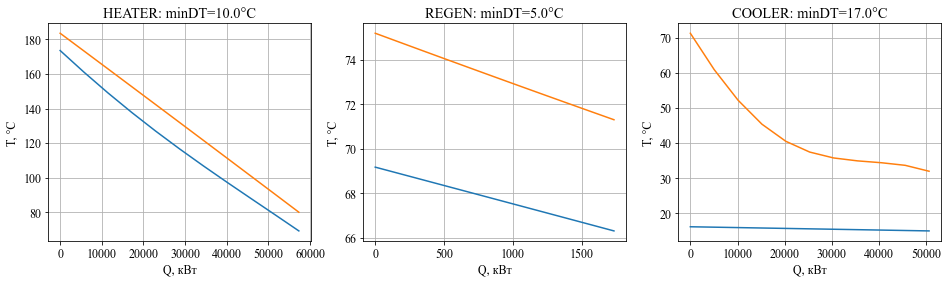

In [3]:
#Вывод T-Q:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
heater.TQ("IN-HEAT","HEAT-OUT","REG-HEAT","HEAT-TURB",gas,fluid,streams)
plt.subplot(1, 3, 2)
regen.TQ("TURB-REG","REG-COND","PUMP-REG","REG-HEAT",fluid,streams)
plt.subplot(1, 3, 3)
cooler.TQ("REG-COND","COND-PUMP","IN-COND","COND-OUT",fluidcond,fluid,streams)
plt.show()